In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("dataset/15min_radiation_data.csv")

# Parsing temporale
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['minute']  = df['time'].dt.minute
df['weekofyr'] = df['time'].dt.isocalendar().week

# Encoding temporale
df['hour_sin']  = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos']  = np.cos(2 * np.pi * df['hour']/24)
df['min_sin']   = np.sin(2 * np.pi * df['minute']/60)
df['min_cos']   = np.cos(2 * np.pi * df['minute']/60)
df['woy_sin']   = np.sin(2 * np.pi * (df['weekofyr']-1)/52)
df['woy_cos']   = np.cos(2 * np.pi * (df['weekofyr']-1)/52)

# Feature e target
features = [
    'Gb(i)','Gd(i)','Gr(i)','H_sun','T2m','WS10m',
    'hour_sin','hour_cos','min_sin','min_cos','woy_sin','woy_cos'
]
target = ['P']

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target])

# Sequence generation
LOOK_BACK = 16
HORIZON = 16

def create_sequences(X, y, look_back=LOOK_BACK, horizon=HORIZON):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back : i + look_back + horizon].flatten())
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Split train/test
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Model build
def build_model(input_shape, horizon):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(LayerNormalization())
    model.add(Dense(horizon))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model((LOOK_BACK, len(features)), HORIZON)
model.summary()

# Training
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# Forecasting
latest_raw = df[features].values[-LOOK_BACK:]
latest_scaled = scaler_X.transform(latest_raw)
latest_input = latest_scaled.reshape((1, LOOK_BACK, len(features)))

pred_scaled = model.predict(latest_input)
pred_raw = scaler_y.inverse_transform(pred_scaled).flatten()
pred = np.clip(pred_raw, 0, None)  # FORCES ALL VALUES TO BE GREATER THAN OR EQUAL TO 0

timestamp_last = pd.to_datetime(df['time'].iloc[-1])
future_idx = pd.date_range(
    start=timestamp_last + pd.Timedelta(minutes=15),
    periods=HORIZON,
    freq='15min'
)
forecast = pd.Series(pred, index=future_idx, name='P_forecast')
print(forecast)


# Store
model.save('pv_lstm_model.h5')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


c:\Users\andre\anaconda3\envs\DMML\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 16, 128)        │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,624 (236.81 KB)

 Trainable params: 60,624 (236.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 144s 33ms/step - loss: 0.0191 - mae: 0.0784 - val_loss: 0.0069 - val_mae: 0.0418
Epoch 2/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 159s 38ms/step - loss: 0.0078 - mae: 0.0512 - val_loss: 0.0078 - val_mae: 0.0518
Epoch 3/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 169s 40ms/step - loss: 0.0070 - mae: 0.0472 - val_loss: 0.0062 - val_mae: 0.0402
Epoch 4/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 165s 39ms/step - loss: 0.0066 - mae: 0.0455 - val_loss: 0.0061 - val_mae: 0.0441
Epoch 5/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 185s 44ms/step - loss: 0.0063 - mae: 0.0436 - val_loss: 0.0065 - val_mae: 0.0468
Epoch 6/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 175s 41ms/step - loss: 0.0061 - mae: 0.0428 - val_loss: 0.0060 - val_mae: 0.0430
Epoch 7/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 165s 39ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0058 - val_mae: 0.0415
Epoch 8/10
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 65s 15ms/step - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0056 - val_mae: 0.0416
Epoch 9/10
4206/4

c:\Users\andre\anaconda3\envs\DMML\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


2023-12-31 23:25:00    0.0
2023-12-31 23:40:00    0.0
2023-12-31 23:55:00    0.0
2024-01-01 00:10:00    0.0
2024-01-01 00:25:00    0.0
2024-01-01 00:40:00    0.0
2024-01-01 00:55:00    0.0
2024-01-01 01:10:00    0.0
2024-01-01 01:25:00    0.0
2024-01-01 01:40:00    0.0
2024-01-01 01:55:00    0.0
2024-01-01 02:10:00    0.0
2024-01-01 02:25:00    0.0
2024-01-01 02:40:00    0.0
2024-01-01 02:55:00    0.0
2024-01-01 03:10:00    0.0
Freq: 15min, Name: P_forecast, dtype: float32


['scaler_y.pkl']

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


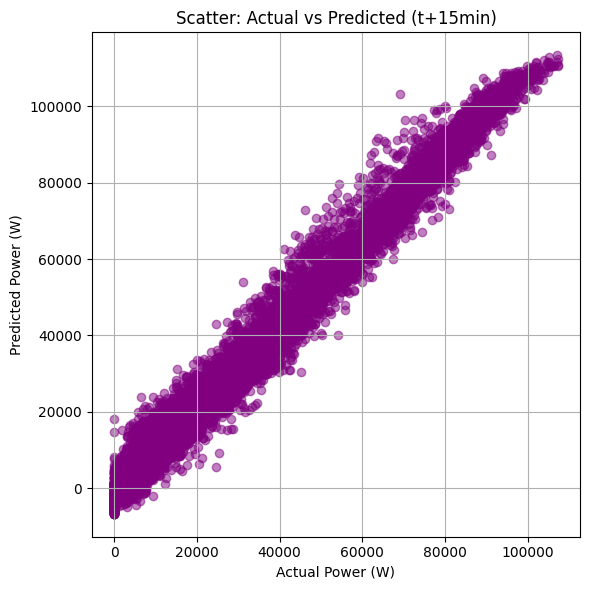

In [26]:
y_pred_scaled = model.predict(X_test)               
y_pred = scaler_y.inverse_transform(y_pred_scaled)  
y_true = scaler_y.inverse_transform(y_test)         

test_start_idx = LOOK_BACK + int(0.8 * len(X_seq))
time_idx = df['time'].iloc[test_start_idx : test_start_idx + len(y_true)].reset_index(drop=True)

# 4. Scatter plot: actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5, color='purple')
plt.xlabel('Actual Power (W)')
plt.ylabel('Predicted Power (W)')
plt.title('Scatter: Actual vs Predicted (t+15min)')
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\andre\anaconda3\envs\DMML\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


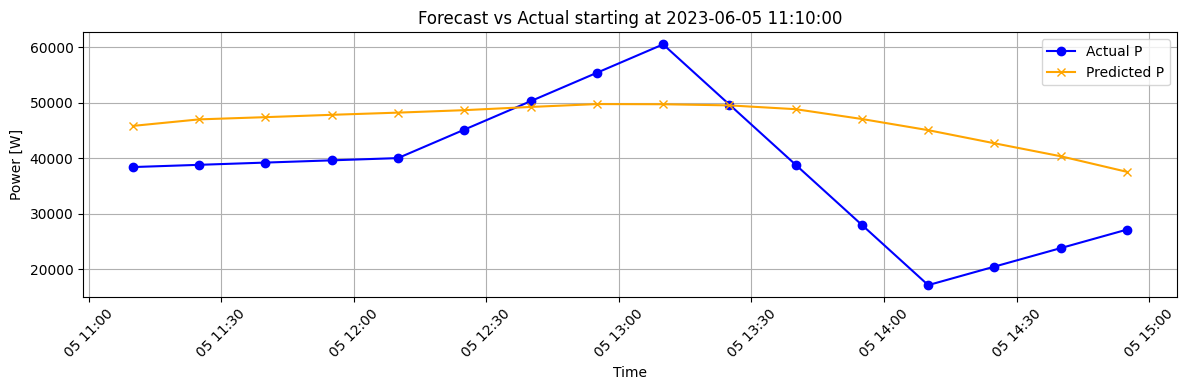

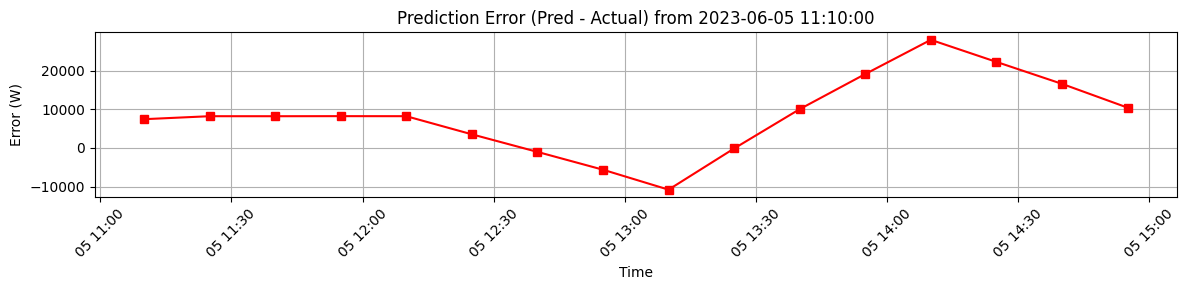

In [27]:
def plot_forecast_at(timestamp_str):
    # 1. Convert string to datetime
    ts = pd.to_datetime(timestamp_str)

    # 2. Check if timestamp exists in the DataFrame
    if ts not in df['time'].values:
        raise ValueError(f"{ts} not found in the 'time' column")

    pos = df[df['time'] == ts].index[0]

    # 3. Make sure there's enough data before and after the timestamp
    if pos < LOOK_BACK or pos + HORIZON >= len(df):
        raise IndexError("Not enough data to construct sequence and make forecast")

    # 4. Prepare input for the model
    raw_input = df[features].iloc[pos - LOOK_BACK:pos].values
    scaled_input = scaler_X.transform(raw_input).reshape(1, LOOK_BACK, len(features))

    # 5. Forecast
    pred_scaled = model.predict(scaled_input)
    pred_raw = scaler_y.inverse_transform(pred_scaled).flatten()
    pred = np.clip(pred_raw, 0, None)  # FORCES ALL VALUES TO BE GREATER THAN OR EQUAL TO 0

    # 6. Get actual values for comparison
    actual = df['P'].iloc[pos:pos + HORIZON].values
    future_times = df['time'].iloc[pos:pos + HORIZON].values

    # Predicted vs Actual
    plt.figure(figsize=(12, 4))
    plt.plot(future_times, actual, label='Actual P', marker='o', color='blue')
    plt.plot(future_times, pred,   label='Predicted P', marker='x', color='orange')
    plt.title(f"Forecast vs Actual starting at {ts}")
    plt.xlabel('Time')
    plt.ylabel('Power [W]')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Forecast Error
    error = pred - actual
    plt.figure(figsize=(12, 3))
    plt.plot(future_times, error, marker='s', linestyle='-', color='red')
    plt.title(f"Prediction Error (Pred - Actual) from {ts}")
    plt.xlabel('Time')
    plt.ylabel('Error (W)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example call
plot_forecast_at("2023-06-05 11:10:00")